In [2]:
import pandas as pd
import tushare as ts
import numpy as np
 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_stock(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print("File loaded.")
    except FileNotFoundError:
        print("Download File!")
        df = ts.get_k_data('000001', start_date, end_date)
        df = df.set_index('date')
        df.to_pickle(output_file)
        print('Downlowd completed!')
    
    return df

In [22]:
daily_001 = load_stock(start_date='2000-01-01', end_date='2022-12-25', output_file='daily_001.pkl')

File loaded.


In [23]:
daily_001 = daily_001.reset_index()

In [24]:
# 上证指数
# 2007年到2016年到数据，用作初始语料库，来训练模型，同时不断扩充历史数据，依次扩充语料库
szzs_00_07 = load_stock(start_date='2000-01-01', end_date='2006-12-31', output_file='szzs_00_07.pkl')
szzs_07_17 = load_stock(start_date='2007-01-01', end_date='2016-12-31', output_file='szzs_07_17.pkl')
szzs_17_22 = load_stock(start_date='2017-01-01', end_date='2022-12-25', output_file='szzs_17_22.pkl')
szzs_07_22 = load_stock(start_date='2007-01-01', end_date='2022-12-25', output_file='szzs_07_22.pkl')

szzs_00_07 = szzs_00_07.reset_index()
szzs_07_17 = szzs_07_17.reset_index()
szzs_17_22 = szzs_17_22.reset_index()
szzs_07_22 = szzs_07_22.reset_index()


Download File!
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
Downlowd completed!
Download File!
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
Downlowd completed!
File loaded.
Download File!
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
Downlowd completed!


In [7]:
szzs_07_17 = szzs_07_17[['date','close']]
all_001 = pd.concat([szzs_07_17, szzs_17_22]).reset_index(drop=True)
all_001

,date,close,open,high,low,volume,code
0,2007-01-04,2.054,NaN,NaN,NaN,NaN,NaN
1,2007-01-05,1.788,NaN,NaN,NaN,NaN,NaN
2,2007-01-08,1.867,NaN,NaN,NaN,NaN,NaN
3,2007-01-09,1.975,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,2.046,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3770,2022-12-19,13.040,13.33,13.47,12.95,1030866.0,000001
3771,2022-12-20,12.760,12.97,13.08,12.67,896212.0,000001
3772,2022-12-21,12.890,12.85,12.99,12.74,614590.0,000001
3773,2022-12-22,12.950,13.00,13.15,12.90,672394.0,000001


In [8]:
from tqdm import tqdm
import itertools

## N元模型
1. 把价格序列 p_series 转换成符号序列 s_series
2. 根据符号序列（过去N天），获得下一个交易日的涨跌概率 （贝叶斯）

In [9]:
class MyCorpus():
    def __init__(self):
        self.freq_dict = {}
        self.p_df_dict = {}
    
    def load_data(self, p_series, N=2, is_renew=False):
        str_s_series = self._generate_str_s_series(p_series)

        # 如果N不存在，在字典里初始化N
        if N not in self.freq_dict or is_renew:
            Ngram_items = [''.join(list(map(lambda x: str(x),i))) for i in itertools.product([1,2], repeat=N)]
            self.freq_dict[N] = {item: 0 for item in Ngram_items}
            self.p_df_dict[N] = None
        
        # 遍历s series，暂存下长度为N的s，并对应样本数量+1
        for i in range(len(str_s_series)-N+1):
            tmp_s = str_s_series[i: i+N]
            self.freq_dict[N][tmp_s] += 1
        
        # 根据freq_dict，把字典里N对应的数据转化成df
        p_df = self._generate_p_df(self.freq_dict[N])
        self.p_df_dict[N] = p_df
    
    def predict_prob(self, p_series):
        N = len(p_series)
        if N not in self.p_df_dict:
            print('没有对应的{}阶模型的统计结果用于预测'.format(N))
            return
        
        str_s_series = self._generate_str_s_series(p_series)
        p_df = self.p_df_dict[N]
        pred_df = p_df[p_df['符号数'].apply(lambda x: x[:N-1]==str_s_series)].copy()
        pred_df = pred_df.sort_values('样本数', ascending=False)
        return pred_df

    def predict(self, p_series):
        pred_df = self.predict_prob(p_series)
        best_symb = pred_df['符号数'].values[0][-1]
        return best_symb
    
    @staticmethod
    def _generate_str_s_series(p_series):
        p_diff_series = (p_series - p_series.shift(1)).dropna()
        s_series = 2 - 1*(p_diff_series<0) # if p_diff_series<0(下跌) then s=1, else （上涨） s=2
        return ''.join(s_series.astype(str))
    
    def _generate_p_df(self, freq_dict):
        p_df = pd.DataFrame([[k,v] for k, v in freq_dict.items()])
        p_df.columns = ['符号数','样本数']
        p_df['频度'] = p_df['样本数'] / p_df['样本数'].sum()
        return p_df

In [10]:
my_corpus = MyCorpus()

""" 生成3-10阶corpus """
my_corpus.load_data(szzs_07_16['close'], 3)
my_corpus.load_data(szzs_07_16['close'], 4)
my_corpus.load_data(szzs_07_16['close'], 5)
my_corpus.load_data(szzs_07_16['close'], 6)
my_corpus.load_data(szzs_07_16['close'], 7)
my_corpus.load_data(szzs_07_16['close'], 8)
my_corpus.load_data(szzs_07_16['close'], 9)
my_corpus.load_data(szzs_07_16['close'], 10)

In [11]:
""" 6阶下的p_df_dict """
my_corpus.p_df_dict[6]

,符号数,样本数,频度
0,111111,21,0.009071
1,111112,21,0.009071
2,111121,29,0.012527
3,111122,28,0.012095
4,111211,33,0.014255
...,...,...,...
59,222122,38,0.016415
60,222211,33,0.014255
61,222212,33,0.014255
62,222221,36,0.015551


In [12]:
my_corpus.predict(all_001['close'][:6])

'2'

## 计算每日信号和止损价格

In [13]:
# 在mkt数据上标记出signal，corpus已经完成了N阶，到first_day(mkt_data)-1日的初始化工作
def calc_signal_and_sl_price(mkt_data, corpus, N, corpus_update_data, sl_perc=0.01):
    first_d_mkt_data = mkt_data['date'].values[0]
    last_d_mkt_data  = mkt_data['date'].values[-1]

    # corpus_update_data 用于不断更新corpus_dict的基础数据
    # 截取corpus_update_data [first_day(mkt_data)-N+1~last_day(mkt_data)]
    match_first_d_idx = corpus_update_data[corpus_update_data['date']==first_d_mkt_data].index[0]
    match_last_d_idx  = corpus_update_data[corpus_update_data['date']==last_d_mkt_data].index[0]
    corpus_update_data = corpus_update_data[match_first_d_idx-N: match_last_d_idx+1]
    corpus_update_p_series = corpus_update_data['close']
    
    # 信号
    signals = []
    # 止损价格
    sl_prices = [np.nan]
    # 用于计算止损价格
    pre_sig = None  
    for i, o in enumerate(tqdm(mkt_data['open'])):
        # 长度为N+1的p_series（即长度为N的s_series）
        tmp_p_series = corpus_update_p_series[i: i+N+1] 
        
        # 过去N+1期p_series(即过去N期s_series)，用来更新Corpus
        corpus.load_data(tmp_p_series, N=N) 
        
        # 过去N期p_series(即过去N-1期s_series)，用来预测当期best_sig（即下期走势）
        pred_p_series = tmp_p_series[1:]
        pred_symb = corpus.predict(pred_p_series)
        sig = 1 if pred_symb=='2' else -1
        
        signals.append(sig)
        
        # 根据pre_sig决定当期sl_price
        if pre_sig:
            sl_price = o * (1 + sl_perc*(pre_sig<0) - sl_perc*(pre_sig>0))
            sl_prices.append(sl_price)

        pre_sig = sig        
        
    mkt_data['signal'] = signals
    mkt_data['sl_price'] = sl_prices
    return mkt_data

## 计算持仓

In [14]:
def calc_position(mkt_data, shift_period=1,is_consider_open=True, is_consider_sl=False, is_daily_close=False,comm = None):
        
    signal = mkt_data['signal']
    position = signal.fillna(method='ffill').shift(shift_period).fillna(0)
    sl_price = mkt_data['sl_price']

    """ A. 是否考虑止损，会根据止损结果重新过滤一遍signal，进而确定position列 """
    if is_consider_sl:        
        """ 1. 计算is_sl：
                - 若持有空仓，sl-h<=0则止损了; 
                - 若持有多仓，l-sl<=0则止损了
        """
        is_sl = (  (-sl_price * np.sign(position))
                 - (mkt_data['high']*(position<0)) 
                 + (mkt_data['low']*(position>0)))<=0
        """ 2. 考虑止损结果生成position """
        #  将止损当期signal设为0（当期signal已为1 or -1，则不变）
        signal_consider_sl = signal.copy()
        signal_consider_sl[(signal_consider_sl.isnull()) & (is_sl)] = 0 
        position = signal_consider_sl.fillna(method='ffill').shift(shift_period).fillna(0)
        """ 3. 空仓期间的is_sl设为False """
        is_sl[position==0] = False
    else:
        is_sl = False
        
    
    """ 生成hold_in_price, hold_out_price """
    # 1. 先初始化 period_out_price = close； period_in_price=close.shift(1)
    open_p, close = mkt_data['open'], mkt_data['close']
    hold_in_price =  close.shift(1).copy()
    hold_in_price[close.index[0]] = open_p.values[0]
    hold_out_price = close.copy()

    # 2. 若考虑持仓信号到第二天开盘才能操作
    if is_consider_open:
        # 2-1. 仓位变动第一期的period_in_price为当日open
        hold_in_price[abs(position - position.shift(1).fillna(0))>0] = open_p
        # 2-2. 仓位变动前最后一期的period_out_price为第二日open (除了整个序列最后一天不变)
        hold_out_price[abs(position - position.shift(-1).fillna(0))>0] = open_p.shift(-1)
        hold_out_price[hold_out_price.index[-1]] = close.values[-1]
    
    # 3. 若考虑止损 （mkt_data要先搭配calc_position()函数，计算得到is_sl列）
    if is_consider_sl:
        # 若当期止损了，hold_out_price设为止损价
        #（若多头，止损为open、sl_price里较低的； 若空头，止损为open、sl_price里较高的）
        hold_out_price[is_sl] = (position>0) * np.minimum(open_p, sl_price) + (position<0) * np.maximum(open_p, sl_price)
        #hold_out_price[is_sl] = (position>0) * np.where(open_p>sl_price, sl_price, open_p) + (position<0) * np.where(open_p>sl_price, open_p, sl_price)
        # 若上期止损了，当期hold_in_price设为开盘价
        sl_next_idxes = mkt_data[is_sl].index.values+1
        sl_next_idxes = sl_next_idxes[sl_next_idxes<=mkt_data.index.values[-1]]
        hold_in_price.loc[sl_next_idxes] = open_p
    
    # 4. 是否每日收盘前平仓
    if is_daily_close:
        daily_last_idxes = mkt_data.drop_duplicates(subset='date', keep='last').index
        hold_out_price.loc[daily_last_idxes.values] = close        
        daily_first_idxes = mkt_data.drop_duplicates(subset='date', keep='first').index
        hold_in_price.loc[daily_first_idxes.values] = open_p
        
    """ 考虑换仓手续费 """ 
    if comm:
        # 换仓后首期 
        if is_consider_sl: # （有止损：仓位相比上期有变动 或 上期止损，当期仓位不为0）
            is_open_pos = ( (abs(position-position.shift(1))>0)|(is_sl.shift(1)) ) * (abs(position)>0)
        else:              # （无止损：仓位相比上期有变动，            当期仓位不为0）
            is_open_pos = (abs(position-position.shift(1))>0) * (abs(position)>0)
        open_pos_comm_perc = 1/(1+comm * is_open_pos)
        # 换仓前末期
        if is_consider_sl: # （有止损：下期仓位有变动 或 当期止损，当期仓位不为0）
            is_close_pos = ( (abs(position-position.shift(-1))>0)|(is_sl) ) * (abs(position)>0)
        else:             # （无止损：下期仓位有变动             ，当期仓位不为0）
            is_close_pos = (abs(position-position.shift(-1))>0) * (abs(position)>0)
        close_pos_comm_perc = (1-comm * is_close_pos)  
    else:
        open_pos_comm_perc = 1.0
        close_pos_comm_perc = 1.0
    
    """ 赋值 """
    mkt_data['position'] = position
    mkt_data['is_sl'] = is_sl
    mkt_data['hold_in_price'] = hold_in_price * abs(np.sign(position))
    mkt_data['hold_out_price'] = hold_out_price * abs(np.sign(position))
    mkt_data['open_pos_comm_perc'] = open_pos_comm_perc
    mkt_data['close_pos_comm_perc'] = close_pos_comm_perc
    return mkt_data

## 策略评估

In [15]:
import datetime

In [16]:
def statistic_performance(mkt_data, 
                          r0=0.03, 
                          data_period=1440,
                          is_consider_sl=False):
    # mkt_data: 回测标的
    # r0: 无风险利率
    # data_period: 1140表示日频数据
    # is_consider_sl：是否考虑止损

    position = mkt_data['position'] #目前仓位
    hold_in_price = mkt_data['hold_in_price'] #入场价格
    hold_out_price = mkt_data['hold_out_price'] #出场价格
    is_sl = mkt_data['is_sl'] #是否止损
    open_pos_comm_perc = mkt_data['open_pos_comm_perc'] #期货开仓手续费百分比
    close_pos_comm_perc = mkt_data['close_pos_comm_perc'] #期货平仓手续费百分比
    
    # 计算【回测数据首日】到【回测数据尾日】的长度（换算为年），用于后续计算年化收益、年化夏普等
    d_first = mkt_data['date'].values[0]
    d_last = mkt_data['date'].values[-1]
    d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
    y_period = d_period.days / 365

    # 持仓收益
    hold_r = position * (hold_out_price/hold_in_price-1)
    # 考虑换仓成本 
    hold_r = open_pos_comm_perc * close_pos_comm_perc * (1+hold_r) - 1
    hold_r.fillna(0.0, inplace=True)
    # 持仓胜负
    hold_win = hold_r>0
    # 累计持仓收益
    hold_cumu_r = (1+hold_r).cumprod() - 1
    # 回撤
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()
    # 超额收益    
    ex_hold_r= hold_r-r0/(250*1440/data_period)
    
    # 把这几列并上去
    mkt_data['hold_r'] = hold_r
    mkt_data['hold_win'] = hold_win
    mkt_data['hold_cumu_r'] = hold_cumu_r
    mkt_data['drawdown'] = drawdown
    mkt_data['ex_hold_r'] = ex_hold_r
    
    # 累计持仓收益
    v_hold_cumu_r = hold_cumu_r.values[-1]

    # 多仓开仓次数
    v_pos_hold_times= 0 
    # 多仓开仓盈利次数
    v_pos_hold_win_times = 0
    # 多仓持有周期数
    v_pos_hold_period = 0
    # 多仓持有盈利周期数
    v_pos_hold_win_period = 0

    # 空仓开仓次数
    v_neg_hold_times= 0 
    # 空仓开仓盈利次数
    v_neg_hold_win_times = 0
    # 空仓持有盈利周期数
    v_neg_hold_period = 0
    # 空仓持有盈利周期数
    v_neg_hold_win_period = 0

    # 多仓止损出局次数
    v_pos_sl_times = 0 
    # 空仓止损出局次数
    v_neg_sl_times = 0

    for w, r, pre_pos, pos, is_lastp_sl in zip(hold_win, hold_r, position.shift(1), position, is_sl.shift(1)):
        if pre_pos!=pos or is_lastp_sl: # 当周期有换仓 or 上期止损（先结算上次持仓，再初始化本次持仓）
            if pre_pos == pre_pos: # pre_pos非空（为空则是循环第一次，无需结算）
                # 结算上一次持仓
                if pre_pos>0: # 多仓
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                    if is_lastp_sl:
                        v_pos_sl_times += 1
                elif pre_pos<0: # 空仓
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
                    if is_lastp_sl:
                        v_neg_sl_times += 1
            # 初始化持仓（每次关仓结算后，或循环第一次时）
            tmp_hold_r = 0
            tmp_hold_period = 0 
            tmp_hold_win_period = 0
        if abs(pos)>0:
            tmp_hold_period += 1
            if r>0:
                tmp_hold_win_period += 1
            if abs(r)>0:
                tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()
    
    v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1
    v_annual_std = ex_hold_r.std() * np.sqrt( len(mkt_data)/y_period ) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    
    v_pos_hold_win_perc = v_pos_hold_win_times/v_pos_hold_times if v_pos_hold_times>0 else np.nan
    v_pos_hold_avg_period = v_pos_hold_period/v_pos_hold_times if v_pos_hold_times>0 else np.nan
    
    v_neg_hold_win_perc = v_neg_hold_win_times/v_neg_hold_times if v_neg_hold_times>0 else np.nan
    v_neg_hold_avg_period = v_neg_hold_period/v_neg_hold_times if v_neg_hold_times>0 else np.nan
    
    v_hold_win_period_perc = v_hold_win_period/v_hold_period if v_hold_period>0 else np.nan
    
    if is_consider_sl:
        v_pos_hold_sl_perc = v_pos_sl_times/v_pos_hold_times if v_pos_hold_times>0 else np.nan
        v_neg_hold_sl_perc = v_neg_sl_times/v_neg_hold_times if v_neg_hold_times>0 else np.nan
        
        performance_cols = ['累计收益', 
                            '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期',
                                        '多仓止损次数', '多仓止损率',
                            '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                                        '空仓止损次数', '空仓止损率',
                            '周期胜率', '最大回撤', '年化收益/最大回撤',
                            '年化收益', '年化标准差', '年化夏普'
                           ]
        performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                              v_pos_hold_times, v_pos_hold_win_times,
                                                '{:.2%}'.format(v_pos_hold_win_perc), 
                                                '{:.2f}'.format(v_pos_hold_avg_period),
                              v_pos_sl_times,   '{:.2%}'.format(v_pos_hold_sl_perc),
                              v_neg_hold_times, v_neg_hold_win_times,
                                                '{:.2%}'.format(v_neg_hold_win_perc), 
                                                '{:.2f}'.format(v_neg_hold_avg_period),
                              v_neg_sl_times,   '{:.2%}'.format(v_neg_hold_sl_perc),
                              '{:.2%}'.format(v_hold_win_period_perc), 
                              '{:.2%}'.format(v_max_dd), 
                              '{:.2f}'.format(v_annual_ret/v_max_dd),
                              '{:.2%}'.format(v_annual_ret), 
                              '{:.2%}'.format(v_annual_std), 
                              '{:.2f}'.format(v_sharpe)
                             ]
    else:
        performance_cols = ['累计收益', 
                            '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                            '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                            '周期胜率', '最大回撤', '年化收益/最大回撤',
                            '年化收益', '年化标准差', '年化夏普'
                           ]
        performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                              v_pos_hold_times, v_pos_hold_win_times,
                                                '{:.2%}'.format(v_pos_hold_win_perc), 
                                                '{:.2f}'.format(v_pos_hold_avg_period),
                              v_neg_hold_times, v_neg_hold_win_times,
                                                '{:.2%}'.format(v_neg_hold_win_perc), 
                                                '{:.2f}'.format(v_neg_hold_avg_period),
                              '{:.2%}'.format(v_hold_win_period_perc), 
                              '{:.2%}'.format(v_max_dd), 
                              '{:.2f}'.format(v_annual_ret/v_max_dd),
                              '{:.2%}'.format(v_annual_ret), 
                              '{:.2%}'.format(v_annual_std), 
                              '{:.2f}'.format(v_sharpe)
                             ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    
    return mkt_data, performance_df

## 整体运行

In [17]:
import warnings
warnings.filterwarnings('ignore')

# 初始化corpus
my_corpus = MyCorpus()

In [19]:
# 交易数据：【2007.01.01 - 2016.12.31】的上证指数数据
bt_data = szzs_07_17

Ns = (3,4,5,6,7,8,9,10)
cumu_nv_df = pd.DataFrame(columns=Ns)
for N in Ns:
    # 初始化Corpus（用【2007.01.01 - 2016.12.31前一天】的上证指数数据作为初始语料库数据）
    my_corpus.load_data(szzs_00_07['close'], N, is_renew=True)
    
    # 滚动计算signal和sl_price
    bt_data = calc_signal_and_sl_price( bt_data, 
                                        my_corpus, 
                                        N, 
                                        all_001)
    # 计算持仓
    bt_data = calc_position(  bt_data, 
                              shift_period=1, 
                              is_consider_open=True, 
                              is_consider_sl=True, 
                              is_daily_close=False,
                              comm = 0.0002,
                             )
    # 策略评估
    res_bt_data, perf_df = statistic_performance(  bt_data, 
                                                   r0=0.03, 
                                                   data_period=1440, 
                                                   is_consider_sl=True
                                                  )
    
    cumu_nv_df[N] = bt_data['hold_cumu_r']+1

cumu_nv_df

100%|██████████| 1454/1454 [00:06<00:00, 228.24it/s]


,3,4,5,6,7,8,9,10
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998563,0.998563,0.997127,0.997127,0.997127,0.997127,0.997127,0.997127
2,0.997330,0.997330,0.996928,0.996729,0.996928,0.996928,0.996928,0.996928
3,1.002051,1.002051,0.992008,1.001447,0.992008,0.992008,0.991810,0.991810
4,1.004135,1.004336,0.994468,0.998764,0.994468,0.994468,0.989152,0.988954
...,...,...,...,...,...,...,...,...
1449,0.879207,1.133329,1.826970,0.753625,0.975082,1.088745,1.317235,3.621483
1450,0.870067,1.121547,1.807977,0.745791,0.964945,1.077427,1.303541,3.583834
1451,0.879871,1.134185,1.813242,0.754194,0.975818,1.089568,1.289989,3.546577
1452,0.870724,1.122394,1.807254,0.746354,0.965674,1.078241,1.276579,3.504253


<AxesSubplot:>

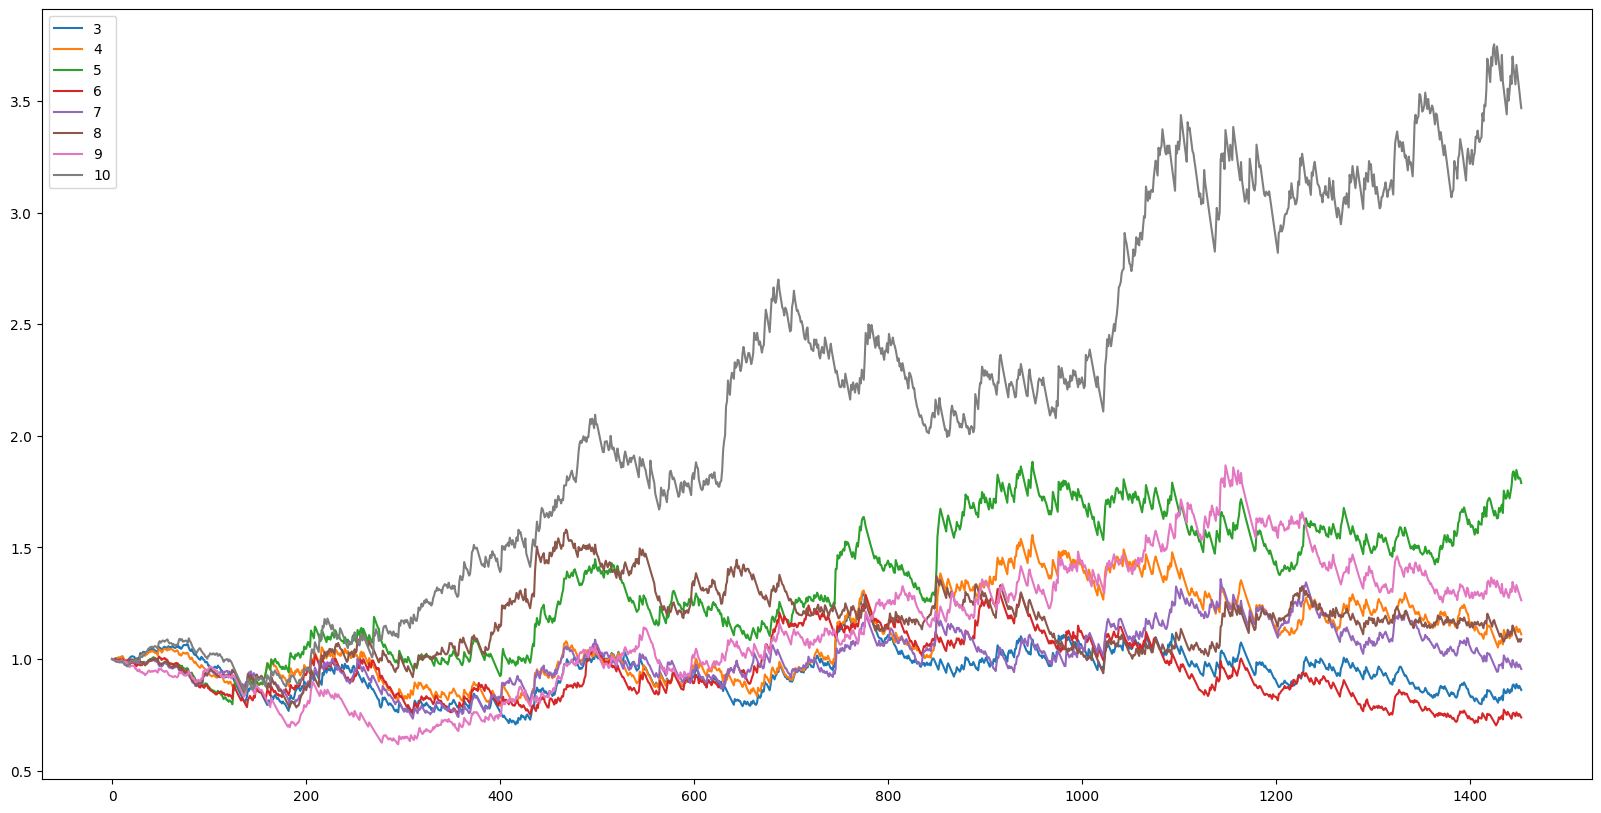

In [20]:
cumu_nv_df.plot(figsize=(20,10))

<AxesSubplot:>

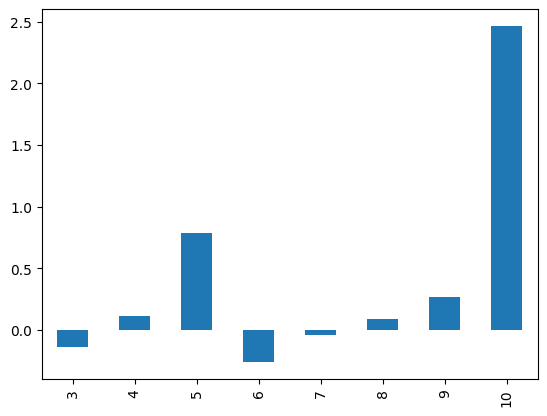

In [21]:
(cumu_nv_df.iloc[-1]-1).plot(kind='bar')